In [5]:
import pretty_midi as pm
import scipy
import os
import matplotlib.pyplot as plt
import glob
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()


if not os.getcwd().endswith("/music"):
   os.chdir("music")
inf = pm.PrettyMIDI('example.mid')
inf.instruments

x = inf.instruments[0]
print(len(x.notes))
print(x.is_drum)
print(x.name)
print(x.get_pitch_class_histogram())

x.program

170
False

[30.  0. 10.  2. 22. 32.  6. 20.  0. 28. 20.  0.]


0

Tempo: 155.833489
(128, 72)


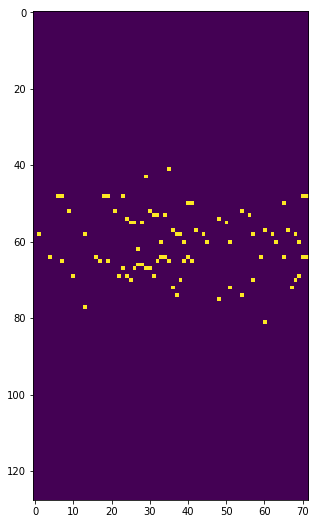

In [6]:
def IsolateMelody(dat):
  interesting = [i for i in dat.instruments if lambda i: len(i.notes)>0 and not i.is_drum]
  interesting = sorted(interesting, reverse=True, key=lambda i: len(i.notes))
  #s = sorted(interesting, key=lambda i: len(i.notes))
  return interesting[0:8]

def MergeInstruments(insts):
  out = insts[0]
  out.name = "merged"
  #print("Base instrument: %s, has %d notes" % (out, len(out.notes)))
  for inst in insts[1:]:
    #print("adding %s, has %d notes" % (inst, len(inst.notes)))
    out.notes += inst.notes
    #print("result: %s has %d notes" % (out, len(out.notes)))
  #print("final result: %s has %d notes" % (out, len(out.notes)))
  return out

inf = pm.PrettyMIDI('example.mid')
out = pm.PrettyMIDI()
out.instruments = [MergeInstruments(IsolateMelody(inf))]
out.write("testout.mid")
print("Tempo: %f" % out.estimate_tempo())
pr = out.get_piano_roll(fs=out.estimate_tempo()/60/2)
#pr = out.get_chroma(times=out.get_beats())
print(pr.shape)

fig = plt.figure(figsize=(14, 9))
ax  = fig.add_subplot(1, 1, 1)
plt.imshow(pr)

Tempo: 191.622565
(128, 290)


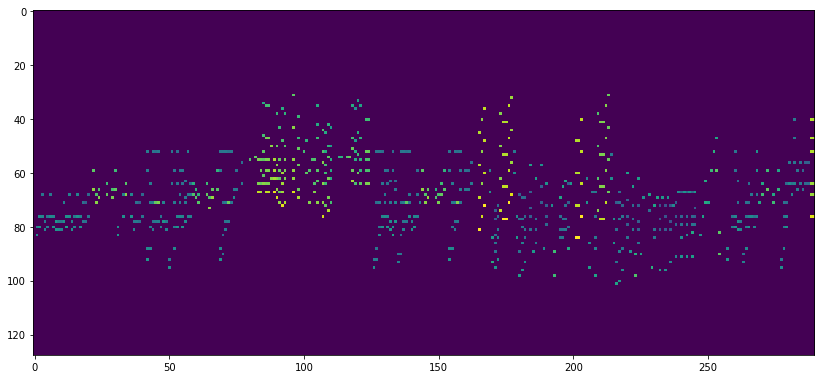

In [8]:
out = pm.PrettyMIDI()
out.instruments = [MergeInstruments(IsolateMelody(pm.PrettyMIDI("ex2.mid")))]
out.write("testout.mid")
print("Tempo: %f" % out.estimate_tempo())
pr = out.get_piano_roll(fs=out.estimate_tempo()/60/2)
print(pr.shape)
fig = plt.figure(figsize=(14, 9))
ax  = fig.add_subplot(1, 1, 1)
plt.imshow(pr)

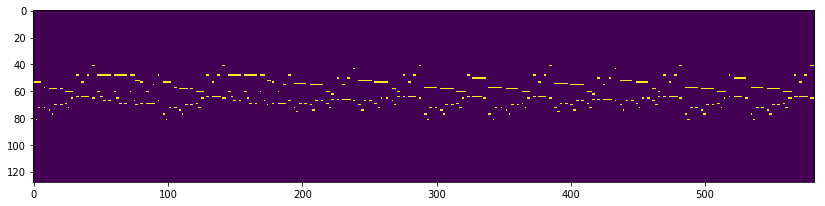

In [10]:
def Datify(file):
  md = pm.PrettyMIDI(file);
  out = pm.PrettyMIDI()
  out.instruments = [MergeInstruments(IsolateMelody(md))]
  dat = {'fs': 512 / out.get_end_time(), 'src': file, 'midi': md, 'simplified': out}
  dat['tempo'] = out.estimate_tempo()
  dat['fs'] = out.estimate_tempo()/60*4
  dat['frames'] = out.get_end_time() / dat['fs']
  dat['pr'] = out.get_piano_roll(dat['fs'])
  return dat
  # pr = out.get_piano_roll(fs=out.estimate_tempo()/60/2)
  #return ExpSeq(pr)

def Sequify(file):
  return Datify(file)['pr'];

def ExpSeq(pr):
  # We need to broadcast the image array such that it has a batch dimension # https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb
  return np.expand_dims(pr, axis=0)

def SqSeq(pr):
  return np.squeeze(pr, axis=0)

def Pr(dat):
  return dat['pr']

def PlotPR(pr):
  fig = plt.figure(figsize=(14, 9))
  ax  = fig.add_subplot(1, 1, 1)
  #img = SqSeq(pr)
  img = pr
  plt.imshow(img)

PlotPR(Sequify("example.mid"))

In [12]:
if True:
  corpus = [Datify(file) for file in sorted(glob.glob("liszt/*.mid"))]

In [13]:
print(len(corpus))
print(corpus[0]['pr'].shape)

11
(128, 13400)


In [14]:
# 学習して生成したpiano rollをmidi fileを元に戻す
import pretty_midi
def piano_roll_to_pretty_midi(piano_roll, fs=100, program=1):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0.004:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = 100 # krispop changed: velocity → 100
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

In [15]:
# 前処理と後処理の確認。corp0-in.midがinput、corp0-simp.midが前処理後、corp0-conv.midが
# corp0-simp.midを一度piano rollに変換した後midiファイルに戻したもの。
np.savetxt("corp0.tsv", corpus[0]['pr'], delimiter="\t")
piano_roll_to_pretty_midi(corpus[0]['pr'], corpus[0]['fs']).write("corp0-conv.mid")
print("Wrote: %s @ %s" % (corpus[0]['src'], corpus[0]['fs']))
corpus[0]['midi'].write("corp0-in.mid")
corpus[0]['simplified'].write("corp0-simp.mid")
print(corpus[0])

Wrote: liszt/liz_donjuan.mid @ 13.260349837994438
{'pr': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'src': 'liszt/liz_donjuan.mid', 'fs': 13.260349837994438, 'midi': <pretty_midi.pretty_midi.PrettyMIDI object at 0xb339f87d0>, 'tempo': 198.90524756991658, 'simplified': <pretty_midi.pretty_midi.PrettyMIDI object at 0xb3391fc10>, 'frames': 76.21065079688408}


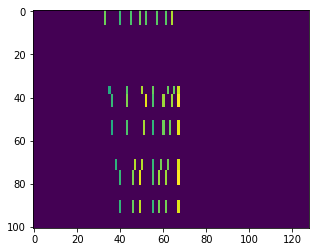

In [16]:
ex = corpus[0]['pr']

#ref https://www.tensorflow.org/tutorials/sequences/text_generation

seq_length = 100
examples_per_epoch = ex.shape[1]
pr_dataset = tf.data.Dataset.from_tensor_slices(ex.T)
pr_dataset.output_shapes

#for i in pr_dataset.take(5):
#  print(i.numpy())
#  print(i.numpy().shape)

sequences = pr_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(3):
  plt.imshow(item.numpy())

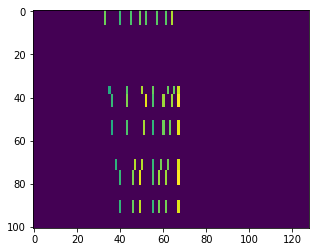

In [20]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

for item in sequences.take(3):
 plt.imshow(item.numpy())

In [19]:
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch//BATCH_SIZE

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences, 
# so it doesn't attempt to shuffle the entire sequence in memory. Instead, 
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
#ref https://www.tensorflow.org/api_docs/python/tf/contrib/data/batch_and_drop_remainder

dataset

<BatchDataset shapes: ((64, 100, 128), (64, 100, 128)), types: (tf.float64, tf.float64)>

In [ ]:
# The embedding dimension
embedding_dim = 256
# The number of notes in one column of piano roll.
keys_dim = 128
rnn_units = 1024

if tf.test.is_gpu_available():
  rnn = tf.keras.layers.CuDNNGRU
else:
  import functools
  rnn = functools.partial(
    tf.keras.layers.GRU, recurrent_activation='sigmoid')
    
def build_model(embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(embedding_dim, 
                              batch_input_shape=[batch_size, keys_dim]),
    rnn(rnn_units,
        return_sequences=True, 
        recurrent_initializer='glorot_uniform',
        stateful=True),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model